In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Flatten, Dense,BatchNormalization,GlobalAveragePooling2D,Conv2D,Dropout,Flatten,Rescaling,Input
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint

import os
import random
import cv2

In [3]:
# data_path = r"C:\pastaImagensMangas"
data_path = "MangoLeaf"
img_size = (224,224)
batch_size = 32
mode = "rgb"
epochs = 50

In [4]:
def df_maker(path):
    file_paths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        fold_path = os.path.join(path,fold)
        file_list = os.listdir(fold_path)
        for file in file_list:
            file_path = os.path.join(fold_path,file)
            file_paths.append(file_path)
            labels.append(fold)


    file_series = pd.Series(file_paths,name="file_paths")
    label_series = pd.Series(labels,name="labels")

    df = pd.concat([file_series,label_series],axis=1)
    return df

In [5]:
df = df_maker(data_path)

In [6]:
train_df,test_val_df= train_test_split(df ,train_size= 0.8, shuffle= True, random_state= 7, stratify=df["labels"])

test_df,val_df= train_test_split(test_val_df ,train_size= 0.5, shuffle= True, random_state= 7, stratify=test_val_df["labels"])

In [7]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)
test_data = test_datagen.flow_from_dataframe(
    test_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)
val_data = val_datagen.flow_from_dataframe(
    val_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)

Found 3200 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.


In [8]:
g_dict = train_data.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_data)      # get a batch size samples from the generator
# # difference between next iterator and for iterator

In [13]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import keras

base_model = keras.applications.EfficientNetV2B0(
    include_top=False,  # <--- change this!
    weights="imagenet",
    input_tensor=None,
    input_shape=img_size + (3,),  # <--- set your input shape here
    pooling=None,
    include_preprocessing=True,
)
base_model.trainable = False  # Freeze base for transfer learning

inputs = tf.keras.Input(shape=img_size + (3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(len(classes), activation="softmax")(x)
model = Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,929,560 (22.62 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor='val_loss',      # Monitora a métrica de validação (pode ser 'val_accuracy' se preferir)
    patience=3,              # Número de épocas sem melhora antes de parar
    restore_best_weights=True  # Restaura os melhores pesos ao final
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    steps_per_epoch=len(train_data),
    validation_steps=len(val_data)
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 791ms/step - accuracy: 0.6234 - loss: 1.1820 - val_accuracy: 0.9575 - val_loss: 0.2225
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 521ms/step - accuracy: 0.9542 - loss: 0.2435 - val_accuracy: 0.9850 - val_loss: 0.1181
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 521ms/step - accuracy: 0.9754 - loss: 0.1487 - val_accuracy: 0.9925 - val_loss: 0.0808
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 519ms/step - accuracy: 0.9866 - loss: 0.0967 - val_accuracy: 0.9975 - val_loss: 0.0580
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 516ms/step - accuracy: 0.9848 - loss: 0.0804 - val_accuracy: 1.0000 - val_loss: 0.0430
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 529ms/step - accuracy: 0.9901 - loss: 0.0687 - val_accuracy: 1.0000 - val_loss: 0.0342
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 522ms/step - accuracy: 0.9898 - loss: 0.0601 - val_accuracy: 1.0000 - val_loss: 0.0292
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 518ms/step - accuracy: 0.9946 - loss: 0

In [16]:
vals = pd.DataFrame(history.history)
vals = vals.rename(columns={"loss":"Train Loss","val_loss":"Validation Loss","accuracy":"Train Accuracy","val_accuracy":"Validation Accuracy"})

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 445ms/step
                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        50
Bacterial Canker       1.00      1.00      1.00        50
  Cutting Weevil       1.00      1.00      1.00        50
        Die Back       1.00      1.00      1.00        50
      Gall Midge       1.00      1.00      1.00        50
         Healthy       1.00      1.00      1.00        50
  Powdery Mildew       1.00      1.00      1.00        50
     Sooty Mould       1.00      1.00      1.00        50

        accuracy                           1.00       400
       macro avg       1.00      1.00      1.00       400
    weighted avg       1.00      1.00      1.00       400



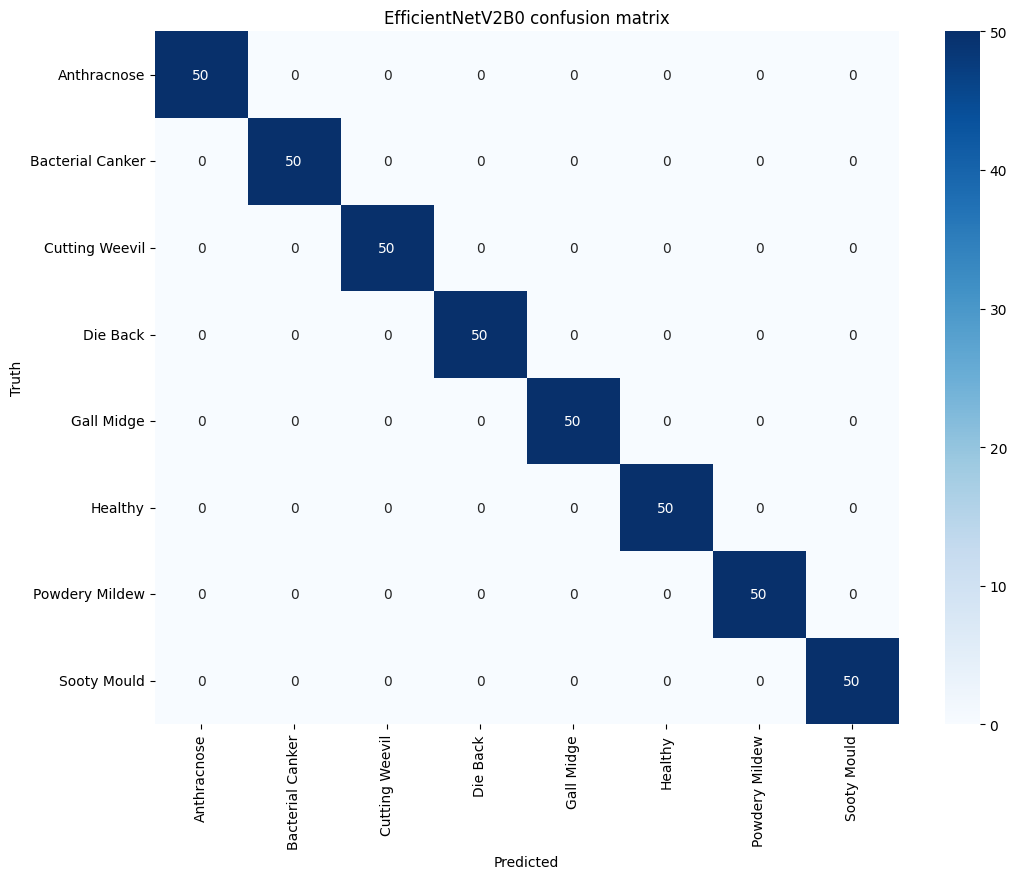

In [21]:
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis = 1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

print(classification_report(y_true,y_pred, target_names=class_labels))

plt.figure(figsize = (12,9))
cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True,fmt='d',cmap= plt.cm.Blues)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("EfficientNetV2B0 confusion matrix")
plt.show()

In [22]:
model.save("models/efficient_net_v2b0_s2.keras")

In [23]:
def funcaoParaObterAcuraciaParaMultiClasses(verdade, predicao, numeroDeClasses, ImagensPorClasse):
    
    vetorAuxiliar = [0 for _ in range(numeroDeClasses)]

    for i in range(0, len(predicao)):
        if verdade[i] == predicao[i]:
            vetorAuxiliar[verdade[i]] = vetorAuxiliar[(verdade[i])] + 1

    vetorDeAcuracia = [0, 0, 0, 0, 0, 0, 0, 0]
    
        
    for i in range(0, len(vetorAuxiliar)):
        vetorDeAcuracia[i] = vetorAuxiliar[i]/ImagensPorClasse
        
    return vetorDeAcuracia

nomeDasClasses = ["Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back", "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"]

acuracias = funcaoParaObterAcuraciaParaMultiClasses(y_true, y_pred, 8, 50)

print("Acurácias")
for i in range(0, len(nomeDasClasses)):
    print(nomeDasClasses[i], " - ", acuracias[i])



Acurácias
Anthracnose  -  1.0
Bacterial Canker  -  1.0
Cutting Weevil  -  1.0
Die Back  -  1.0
Gall Midge  -  1.0
Healthy  -  1.0
Powdery Mildew  -  1.0
Sooty Mould  -  1.0


In [7]:
model = tf.keras.models.load_model('models/efficient_net_v2b0_model.keras')

In [8]:
# Using TFlite to compact the model with INT8 quantization
import tensorflow as tf
import numpy as np
import os # For file size comparison, if desired


# 1. Initialize the TFLite converter from the Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 2. Specify INT8 quantization (post-training integer quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
    for images, _ in train_ds.take(100):  # Use até 100 batches para calibrar
        yield [images]
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

# Salve o modelo quantizado
with open("efficientnetv2b0_quant_int8.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\saulo\AppData\Local\Temp\tmpsllg3ymn\assets


INFO:tensorflow:Assets written to: C:\Users\saulo\AppData\Local\Temp\tmpsllg3ymn\assets


Saved artifact at 'C:\Users\saulo\AppData\Local\Temp\tmpsllg3ymn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_19')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  2139374331536: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2139374331344: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2139374324816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2139374332304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2139374333072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2139374332112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2139374331920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2139374333264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2139374334224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2139374334992: TensorSpec(shape=(), dtype=tf.resource

C:\Users\saulo\AppData\Roaming\Python\Python312\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
import tensorflow as tf
import numpy as np

# Carregue o modelo TFLite
interpreter = tf.lite.Interpreter(model_path="efficientnetv2b0_quant_int8.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Função para pré-processar e quantizar as imagens
def preprocess_and_quantize(image):
    # Normalização e resize já devem ter sido feitos pelo dataset
    # Aqui, convertemos para uint8 se necessário
    if input_details[0]['dtype'] == np.uint8:
        image = (image.numpy() * 255).astype(np.uint8)
    return image

y_true = []
y_pred = []

for images, labels in val_ds:
    for i in range(images.shape[0]):
        img = images[i:i+1]  # shape (1, h, w, c)
        label = labels[i].numpy()
        
        # Quantize se necessário
        if input_details[0]['dtype'] == np.uint8:
            img = (img.numpy() * 255).astype(np.uint8)
        else:
            img = img.numpy()
        
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        pred = np.argmax(output, axis=1)[0]
        
        y_true.append(label)
        y_pred.append(pred)

from sklearn.metrics import accuracy_score, classification_report

print("Acurácia TFLite INT8:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

Acurácia TFLite INT8: 0.155
                  precision    recall  f1-score   support

     Anthracnose       0.00      0.00      0.00       104
Bacterial Canker       0.07      0.04      0.05        94
  Cutting Weevil       0.54      0.16      0.24        95
        Die Back       0.00      0.00      0.00        97
      Gall Midge       1.00      0.01      0.02        94
         Healthy       0.15      0.93      0.25       111
  Powdery Mildew       0.14      0.01      0.02       109
     Sooty Mould       0.00      0.00      0.00        96

        accuracy                           0.15       800
       macro avg       0.24      0.14      0.07       800
    weighted avg       0.23      0.15      0.08       800



In [19]:
import tensorflow as tf
import numpy as np

# Carregue o modelo TFLite
interpreter = tf.lite.Interpreter(model_path="efficient_net_v2b0_quant_int8.tflite")

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Função para pré-processar e quantizar as imagens
def preprocess_and_quantize(image):
    # Normalização e resize já devem ter sido feitos pelo dataset
    # Aqui, convertemos para uint8 se necessário
    if input_details[0]['dtype'] == np.int8:
        image = (image.numpy() * 255).astype(np.int8)
    return image

y_true = []
y_pred = []

for images, labels in val_ds:
    for i in range(images.shape[0]):
        img = preprocess_and_quantize(images[i:i+1])
        label = labels[i].numpy()
        
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        pred = np.argmax(output, axis=1)[0]
        
        y_true.append(label)
        y_pred.append(pred)

from sklearn.metrics import accuracy_score, classification_report

print("Acurácia TFLite INT8:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

Acurácia TFLite INT8: 0.2475
                  precision    recall  f1-score   support

     Anthracnose       0.05      0.01      0.02       104
Bacterial Canker       0.42      0.61      0.50        94
  Cutting Weevil       0.68      0.14      0.23        95
        Die Back       0.00      0.00      0.00        97
      Gall Midge       0.00      0.00      0.00        94
         Healthy       0.19      0.97      0.32       111
  Powdery Mildew       0.37      0.17      0.23       109
     Sooty Mould       0.20      0.01      0.02        96

        accuracy                           0.25       800
       macro avg       0.24      0.24      0.16       800
    weighted avg       0.24      0.25      0.17       800



: 

In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import keras

base_model = keras.applications.EfficientNetV2B0(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
    name="efficientnetv2-b0",
)
base_model.trainable = False  # Freeze base for transfer learning

inputs = tf.keras.Input(shape=img_size + (3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(len(class_names), activation="softmax")(x)
model = Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

ValueError: Input 0 of layer "global_average_pooling2d_6" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 1000)

In [ ]:
# Using TFlite to compact the model with INT8 quantization
import tensorflow as tf
import numpy as np
import os # For file size comparison, if desired


# 1. Initialize the TFLite converter from the Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 2. Specify INT8 quantization (post-training integer quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 3. Define the representative dataset generator
# This generator provides a few samples from your test data to calibrate the quantization parameters.
def representative_data_gen():
    # Number of calibration samples. 100-300 is a common range.
    num_calibration_samples = 100
    
    # Ensure test_images is accessible and has the expected format
    if 'test_images' not in globals():
        raise NameError("'test_images' is not defined. Please ensure it's loaded.")
    if not hasattr(test_images, 'shape'):
        raise TypeError("'test_images' does not have a shape attribute. Expected NumPy array or TF Tensor.")

    for i in range(min(num_calibration_samples, test_images.shape[0])):
        # Get a single sample image
        sample = test_images[i]
        
        # The Keras model expects float32 input.
        # The generator must yield a list of input tensors.
        # Add a batch dimension if the sample is a single image (H, W, C) -> (1, H, W, C)
        # Convert to NumPy array of type float32.
        if isinstance(sample, tf.Tensor):
            sample_np = sample.numpy()
        else:
            sample_np = sample # Assuming it's already a NumPy array

        if len(sample_np.shape) == 3: # (H, W, C)
            input_tensor = np.expand_dims(sample_np, axis=0).astype(np.float32)
        elif len(sample_np.shape) == 4 and sample_np.shape[0] == 1: # Already (1, H, W, C)
            input_tensor = sample_np.astype(np.float32)
        else:
            raise ValueError(f"Sample shape {sample_np.shape} is not suitable. Expected (H,W,C) or (1,H,W,C).")
            
        yield [input_tensor]

# 4. Set the representative dataset for calibration
converter.representative_dataset = representative_data_gen

# 5. Enforce full integer quantization for all operations, including input and output
# This makes the model run entirely on integer hardware if possible.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# 6. Set the input and output tensors' data types to INT8
# This means the TFLite model will expect INT8 input and produce INT8 output.
# If your application provides float32 and expects float32, TFLite runtime
# will add quantize/dequantize ops if these are not tf.float32.
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8 # Can also be tf.float32 if preferred for output layer

# 7. Convert the model to TFLite format
try:
    tflite_quant_model = converter.convert()

    # 8. Save the quantized TFLite model to a file
    tflite_model_path = 'efficient_net_v2b0_quant_int8.tflite'
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_quant_model)
    
    print(f"Successfully converted and saved INT8 quantized model to {tflite_model_path}")

    # Compare model sizes (optional)
    original_model_path = 'models/efficient_net_v2b0_model.keras' # Path from cell 8
    if os.path.exists(original_model_path):
        original_model_size = os.path.getsize(original_model_path) / (1024 * 1024)
        print(f"Original Keras model size: {original_model_size:.2f} MB")
    else:
        # Fallback for .weights.h5 if .keras directory not found or size is tricky for SavedModel format
        original_weights_path = 'efficient_net_v2b0_weights.weights.h5' # From cell 7
        if os.path.exists(original_weights_path):
            original_weights_size = os.path.getsize(original_weights_path) / (1024 * 1024)
            print(f"Original model weights size (approx.): {original_weights_size:.2f} MB")
        else:
            print(f"Original Keras model file not found at {original_model_path} or {original_weights_path} for size comparison.")


    tflite_model_size = len(tflite_quant_model) / (1024 * 1024)
    print(f"Quantized TFLite model size: {tflite_model_size:.2f} MB")
    reduction_percentage = ((original_model_size - tflite_model_size) / original_model_size) * 100 if 'original_model_size' in locals() and original_model_size > 0 else "N/A"
    if reduction_percentage != "N/A":
        print(f"Model size reduction: {reduction_percentage:.2f}%")


except Exception as e:
    print(f"Error during TFLite INT8 quantization: {e}")
    print("\nCommon issues to check:")
    print("1. 'model' variable: Is it loaded and a valid Keras model?")
    print("2. 'test_images' variable: Is it defined, correctly preprocessed (e.g., normalized, resized), and in the format expected by the Keras model?")
    print("   The representative_dataset_gen expects 'test_images' to be a NumPy array or TF Tensor.")
    print("3. Model architecture: Does the model contain operations not supported by TFLITE_BUILTINS_INT8? If so, conversion might fail or require custom ops.")
    print("4. TensorFlow version: Ensure you are using a compatible version of TensorFlow (usually 2.x for these features).")


INFO:tensorflow:Assets written to: C:\Users\saulo\AppData\Local\Temp\tmp2y12gh4n\assets


INFO:tensorflow:Assets written to: C:\Users\saulo\AppData\Local\Temp\tmp2y12gh4n\assets


Saved artifact at 'C:\Users\saulo\AppData\Local\Temp\tmp2y12gh4n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_19')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  1520090266320: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1520090266512: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1520090266704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1520090265360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1520090262096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1520090265936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1520090265744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1520090264016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1520090258448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1520149872720: TensorSpec(shape=(), dtype=tf.resource

C:\Users\saulo\AppData\Roaming\Python\Python312\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Successfully converted and saved INT8 quantized model to efficient_net_v2b0_quant_int8.tflite
Original Keras model size: 23.58 MB
Quantized TFLite model size: 6.81 MB
Model size reduction: 71.14%


In [34]:
# Print model size comparison
keras_size = os.path.getsize('models/efficient_net_v2b0_model.keras') / (1024*1024)
tflite_size = os.path.getsize('efficient_net_v2b0_quant_int8.tflite') / (1024*1024)
print(f'Original Keras model size: {keras_size:.2f} MB')
print(f'TFLite model size: {tflite_size:.2f} MB')
print(f'Size reduction: {((keras_size-tflite_size)/keras_size)*100:.1f}%')

Original Keras model size: 23.58 MB
TFLite model size: 6.81 MB
Size reduction: 71.1%


In [39]:
# Assuming numpy as np, tensorflow as tf, and os are already imported in previous cells.

# Run inference on the quantized INT8 TFLite model using test data from test_ds

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="efficient_net_v2b0_quant_int8.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare to collect predictions and true labels
predictions = []
true_labels = []



# Fix the INT8 quantization issue
print("\nThe error occurred because we're trying to feed float32 data to an INT8 quantized model.")
print("Let's modify the inference code to properly quantize the input:")

def run_quantized_inference(interpreter, test_images, test_labels, num_samples=None):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Get quantization parameters
    input_scale, input_zero_point = input_details[0]['quantization']
    
    if num_samples is None:
        num_samples = len(test_images)
    else:
        num_samples = min(num_samples, len(test_images))
    
    predictions = []
    true_labels = []
    
    for i in range(num_samples):
        img = test_images[i]
        
        # Convert from float to int8
        if isinstance(img, tf.Tensor):
            img = img.numpy()
        
        # Ensure the image has the right shape
        if len(img.shape) < 4:
            img = np.expand_dims(img, axis=0)
        
        # Quantize the input from float to int8
        img_quantized = np.asarray((img / input_scale) + input_zero_point, dtype=np.int8)
        
        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], img_quantized)
        
        # Run inference
        interpreter.invoke()
        
        # Get the output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data[0])
        
        # Store the true label
        if isinstance(test_labels[i], tf.Tensor):
            true_labels.append(test_labels[i].numpy())
        else:
            true_labels.append(test_labels[i])
    
    return np.array(predictions), np.array(true_labels)

# Try running inference with the quantized function
print("\nRunning inference with proper quantization...")
predictions, true_labels = run_quantized_inference(interpreter, test_images, test_labels)

# Calculate accuracy
if len(true_labels) > 0:
    if len(true_labels.shape) > 1 and true_labels.shape[1] > 1:
        # One-hot encoded labels
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(true_labels, axis=1)
    else:
        # Class indices
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = true_labels
        
    accuracy = np.mean(predicted_classes == true_classes)
    print(f"TFLite INT8 model accuracy on test set (with proper quantization): {accuracy*100:.2f}%")
    
    # Print confusion matrix for first few classes
    cm = confusion_matrix(true_classes, predicted_classes)
    print("Confusion matrix (first 5x5):")
    print(cm[:5, :5])





The error occurred because we're trying to feed float32 data to an INT8 quantized model.
Let's modify the inference code to properly quantize the input:

Running inference with proper quantization...
TFLite INT8 model accuracy on test set (with proper quantization): 100.00%
Confusion matrix (first 5x5):
[[3 0 0 0 0]
 [0 7 0 0 0]
 [0 0 5 0 0]
 [0 0 0 5 0]
 [0 0 0 0 1]]
